In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [3]:
account_activity = pd.read_csv("Data/Customer Profiles/account_activity.csv")
customer_data = pd.read_csv("Data/Customer Profiles/customer_data.csv")        # contains vendor rating
fraud_indicators= pd.read_csv("Data/Fraudulent Patterns/fraud_indicators.csv")    # contains lat/long
suspicious_activity = pd.read_csv("Data/Fraudulent Patterns/suspicious_activity.csv")
merchant_data = pd.read_csv("Data/Merchant Information/merchant_data.csv")
transaction_category_labels = pd.read_csv("Data/Merchant Information/transaction_category_labels.csv")
amount_data= pd.read_csv("Data/Transaction Amounts/amount_data.csv")
anomaly_scores = pd.read_csv("Data/Transaction Amounts/anomaly_scores.csv")
transaction_metadata = pd.read_csv("Data/Transaction Data/transaction_metadata.csv")
transaction_records = pd.read_csv("Data/Transaction Data/transaction_records.csv")

In [4]:
account_activity.columns

Index(['CustomerID', 'AccountBalance', 'LastLogin'], dtype='object')

In [5]:
customer_data.columns

Index(['CustomerID', 'Name', 'Age', 'Address'], dtype='object')

In [6]:
fraud_indicators.columns

Index(['TransactionID', 'FraudIndicator'], dtype='object')

In [7]:
suspicious_activity.columns

Index(['CustomerID', 'SuspiciousFlag'], dtype='object')

In [8]:
merchant_data.columns

Index(['MerchantID', 'MerchantName', 'Location'], dtype='object')

In [9]:
transaction_category_labels.columns

Index(['TransactionID', 'Category'], dtype='object')

In [10]:
amount_data.columns

Index(['TransactionID', 'TransactionAmount'], dtype='object')

In [11]:
anomaly_scores.columns

Index(['TransactionID', 'AnomalyScore'], dtype='object')

In [12]:
transaction_metadata.columns

Index(['TransactionID', 'Timestamp', 'MerchantID'], dtype='object')

In [13]:
transaction_records.columns

Index(['TransactionID', 'Amount', 'CustomerID'], dtype='object')

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder


In [15]:
# Start with transaction_records
df = transaction_records.copy()

# Add Transaction Amount (rename to avoid duplicate column names)
df = df.merge(amount_data, on='TransactionID', how='left')
df = df.merge(transaction_metadata, on='TransactionID', how='left')
df = df.merge(transaction_category_labels, on='TransactionID', how='left')
df = df.merge(anomaly_scores, on='TransactionID', how='left')
df = df.merge(fraud_indicators, on='TransactionID', how='left')  # Target column

# Add Customer info
df = df.merge(customer_data, on='CustomerID', how='left')
df = df.merge(account_activity, on='CustomerID', how='left')
df = df.merge(suspicious_activity, on='CustomerID', how='left')

In [16]:
# Add Merchant info
df = df.merge(merchant_data, on='MerchantID', how='left')

In [17]:
# Drop rows where target is missing
df = df.dropna(subset=["FraudIndicator"])

In [18]:
# Encode categorical columns
cat_cols = df.select_dtypes(include=['object']).columns

In [19]:
le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col].astype(str))

In [20]:

# Fill any remaining missing values
df = df.fillna(0)


In [28]:
df.head()

,TransactionID,Amount,CustomerID,TransactionAmount,Timestamp,MerchantID,Category,AnomalyScore,FraudIndicator,Name,Age,Address,AccountBalance,LastLogin,SuspiciousFlag,MerchantName,Location,FraudPrediction
0,1,55.530334,1952,79.413607,0,2701,2,0.686699,0,597,50,597,2869.689912,597,0,446,446,0
1,2,12.881180,1027,12.053087,1,2070,1,0.081749,0,19,46,19,9527.947107,19,0,43,43,0
2,3,50.176322,1955,33.310357,2,2238,4,0.023857,0,600,34,600,9288.355525,600,0,147,147,0
3,4,41.634001,1796,46.121117,3,2879,4,0.876994,0,512,33,512,5588.049942,512,0,566,566,0
4,5,78.122853,1946,54.051618,4,2966,2,0.034059,0,593,18,593,7324.785332,593,0,629,629,0


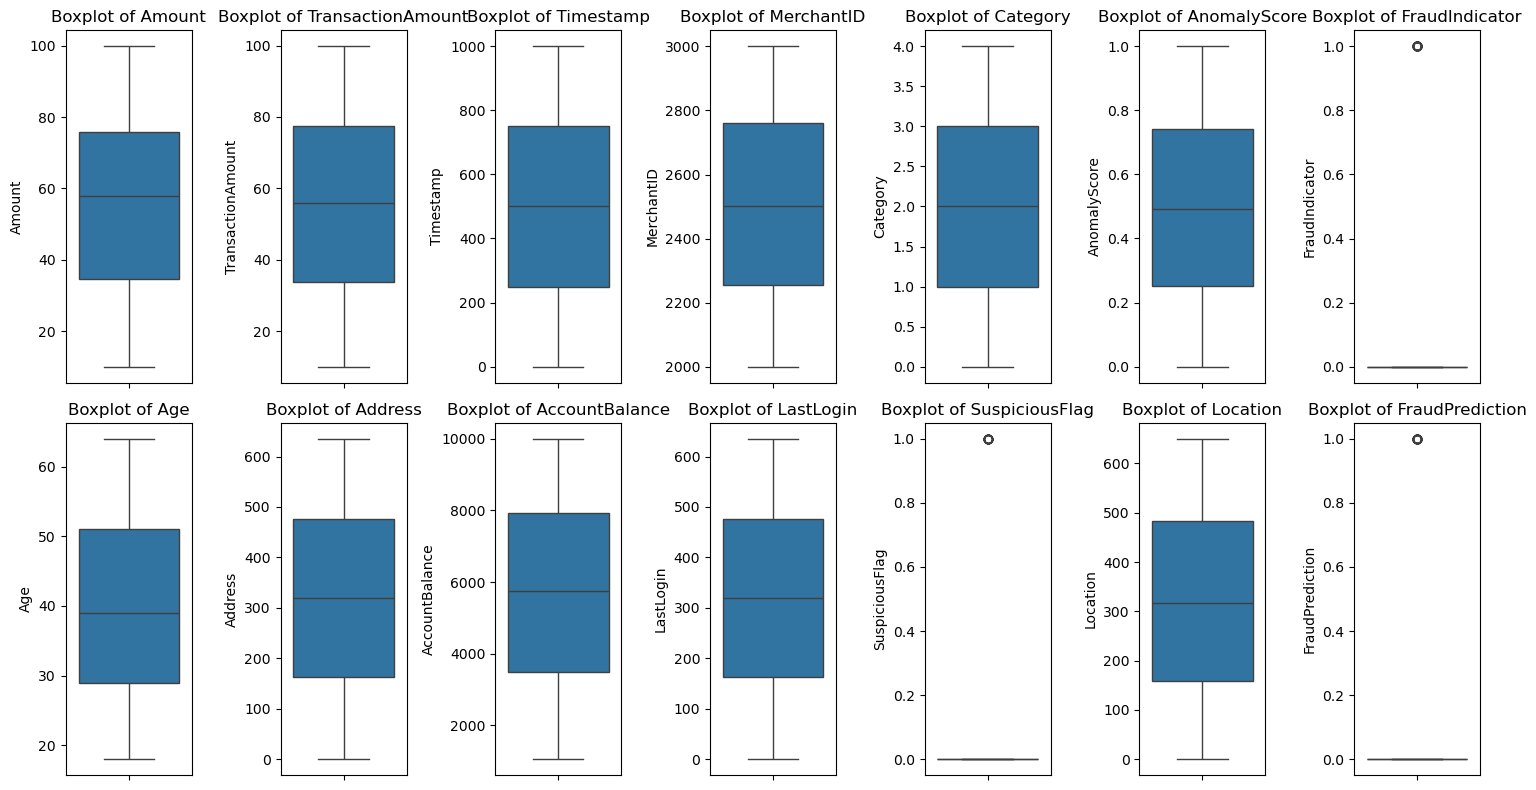

In [30]:
# Boxplots
plt.figure(figsize=(15, 8))
for i, col in enumerate(['Amount','TransactionAmount','Timestamp','MerchantID','Category','AnomalyScore',
                         'FraudIndicator','Age','Address','AccountBalance','LastLogin','SuspiciousFlag',
                         'Location','FraudPrediction']):
    plt.subplot(2, 7, i+1)
    sns.boxplot(df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

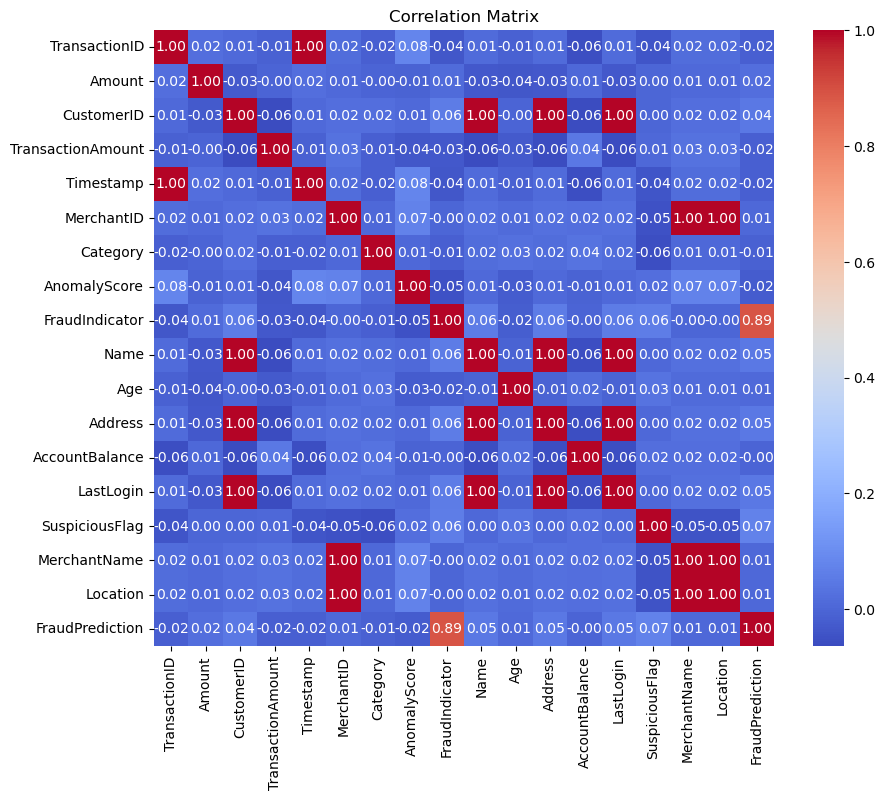

In [33]:
numeric_data = df.select_dtypes(include=[np.number])
corr_matrix = numeric_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [22]:
# 3️⃣ TRAIN-TEST SPLIT & MODEL
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [23]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    class_weight='balanced',
    random_state=42
)


In [24]:
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [27]:
model_score_test= model.score(X_test,y_test)
print(model_score_test)

0.955


In [25]:
# ------------------------------
# 4️⃣ EVALUATION
# ------------------------------
print("\n Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n Classification Report:\n", classification_report(y_test, y_pred))


 Confusion Matrix:
 [[191   0]
 [  9   0]]

 Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       191
           1       0.00      0.00      0.00         9

    accuracy                           0.95       200
   macro avg       0.48      0.50      0.49       200
weighted avg       0.91      0.95      0.93       200



C:\Users\ramya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ramya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ramya\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [26]:
# Add predictions back to dataset for dashboard use
df['FraudPrediction'] = model.predict(X)